Link to thin notebook on Gist:
https://gist.github.com/MoGaber/899d51e7e7e2932baeac2f30376537fa

## CS166 - Assignment 2 - Traffic Simulation

In [4]:
#importing the necessary Libraries:
#pygame for building a graphical simulation:
import pygame
import sys
import math
from pygame import *
from pygame.locals import *
from pygame.sprite import *

import matplotlib
import pylab
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn



pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## Traffic Simulation For N-lane Road

In [2]:
class TrafficSimulator(object):


    def __init__(self,road_length, traffic_density,  max_velocity,prob_slowdown, lanes_num, prob_change_lane):
       
        self.road_length = road_length #number of cells in the road
        self.traffic_density = traffic_density 
        self.max_velocity = max_velocity
        self.prob_slowdown= prob_slowdown #probability of random slow down
        self.prob_change_lane= prob_change_lane #probability of changing lanes
        self.flow_rate_counter = 0 #counting the flow rate variable
        self.lanes_num = lanes_num #number of lanes
        
        #The current and next state as nxn numpy array with -1s where each array is a lane
        self.current_state = np.array([[-1 for i in range(self.road_length)]]*self.lanes_num)
        self.next_state = np.array([[-1 for i in range(self.road_length)]]*self.lanes_num)
    
    
    def initialize(self):
        #for each lane, I assign a car at random index
       
        for i in range(self.lanes_num):
            random_indices = np.random.choice(
                range(self.road_length),
                size=int(round(self.traffic_density * self.road_length)),
            replace=False)        
             #All Cars start at 0
            self.current_state[i,random_indices] = 0
        
        #counting the time steps
        self.time = 0
        
    #a function to visualize the traffic over time     
    def display(self):
        
        print('*'*self.road_length)#print a line to distinguish lanes
        for i in range(self.lanes_num):
            print(''.join('.' if x == -1 else str(x) for x in self.current_state[i]))

    #A function to update our states at each time step
    #the index in the function refers to the lane array
    def update_lane(self, index):
        
        #for each cell in the road 
        for i in range(self.road_length):
            if self.current_state[index][i] !=-1: #if it's not an empty cell
                
                #calculate how many spaces are available for that car
                spaces = 1 
                while self.current_state[index][(i+spaces)%len(self.current_state[index])] ==-1:
                    spaces+=1
                
                #accelerate it
                if self.current_state[index][i] < self.max_velocity :
                        self.current_state[index][i] = self.current_state[index][i]+1
                #decelerate it   
                if spaces <= self.current_state[index][i]:
                        self.current_state[index][i] = spaces-1
                
                #randomization step for slowing down the car
                if self.current_state[index][i]>0 and random.random() < self.prob_slowdown:
                        self.current_state[index][i] = self.current_state[index][i]-1
        
        
        #After updating the velocity of each car, we can start moving them
        for j in range(self.road_length):
            #the modulo operator is used to make sure we don't run out of index of the array
            if self.current_state[index][j] != -1:
                self.next_state[index][(j+self.current_state[index][j])%len(self.next_state[index])
                                      ] = self.current_state[index][j]
        
        
        #updating the current state after movement
        self.current_state[index] =  self.next_state[index]
        #restarting the next state so we can use it again
        self.next_state = np.array([[-1 for i in range(self.road_length)]]*self.lanes_num)
        
       
        #calculating flow_rate
        for i in range(self.max_velocity):
            #if car at cell i have enough velocity that indicates that 
            #it passed through the first two cells:
            if self.current_state[index][i] >i:
                self.flow_rate_counter+=1
    
       
    # A function to implement lane changes
    def change_lane(self, index_1):
        #index_1 refers to the lane array
        #index_2 refers to the lane to which the car will go
        index_2 = (index_1+1)%self.lanes_num #modulo to make sure the index stays in range(0, lanes_number)
        
        #for each cell:
        for i in range(self.road_length):
            #if it's not an empty cell:
            if self.current_state[index_1][i] !=-1:
                
                #calculate the gaps in front of this cell
                forward_gaps_l = 0 
                while self.current_state[index_1][(i+forward_gaps_l+1)%len(self.current_state[index_1])] ==-1:
                    forward_gaps_l+=1
                
                #if gaps in front of this car are not enough, look at the other lane:
                num_1=self.current_state[index_1][i]+1
                # num_1 is the velocity +1 I use num_1 - (num_1//6) to make sure that when I add 
                # 1 to the current velocity, it doesn't go more than 5 (maximum velocity)
                if forward_gaps_l < (num_1 - (num_1//6)):
                    
                    #calculate gaps on the other lane:
                    forward_spaces_lo = -1 
                    while self.current_state[index_2][(i+forward_spaces_lo+1)%len(self.current_state[index_1])] ==-1:
                        forward_spaces_lo+=1
                        #this while loop must break once we know that the other lane has more gaps
                        #than the first lane (otherwise the loop will keep going forever if this lane is empty)
                        num_2 = self.current_state[index_1][i]+1
                        if forward_spaces_lo >= (num_2 - (num_2//6)):
                            break
                    
                    #if gaps on other lane are more than the first lane:
                    num_2 = self.current_state[index_1][i]+1
                    if forward_spaces_lo >= (num_2 - (num_2//6)):
                        #look behind to make sure no car is approaching:
                        cars_behind = False
                        for j in range(self.max_velocity+1):
                            #if there is a car coming:
                            if self.current_state[index_2][i-j]!=-1 and self.current_state[index_2][i-j] >=j-1:
                                #then don't change
                                cars_behind = True
                        #if no car is coming, then change lanes
                        if not cars_behind and random.random() < self.prob_change_lane:
                            self.current_state[index_2][i] = self.current_state[index_1][i]
                            self.current_state[index_1][i] = -1
                    
    #finally, a function to use all the above functions and start the simulation
    def update(self):
        #for each lane, do the change lanes:
        if self.lanes_num>1:
            for i in range(self.lanes_num):
                self.change_lane(i)
        #For each lane, update it separately
        for i in range(self.lanes_num):
            self.update_lane(i)
        #Update time
        self.time += 1


### Visualizing the state of a single-lane road over time

In [3]:
sim = TrafficSimulator(road_length=100, traffic_density=0.4,  max_velocity=5,prob_slowdown=0.5, 
                       lanes_num=1, prob_change_lane=0.95)
sim.initialize()
sim.display()


for i in range(50):
    sim.update()
    sim.display()

****************************************************************************************************
...0.0...00...0.0.00000...000.0..0....0..0...0...000000.....00.....00....0000....0...00....0.0.0..0.
****************************************************************************************************
....10...0.1...1.100000...00.1.1..1....1.0...0...000000.....0.1....00....000.1...0...0.1...0..10..0.
****************************************************************************************************
....0.1...1..2..1000000...0.1.1..2..2..0..1...1..00000.1....0...2..00....000..1..0....1.1..0..00..0.
****************************************************************************************************
.....1.1...1..1.0000000...0.0...2..2.1.0....2..1.0000.1..2...1....200....000....20.....1..20..0.1..1
****************************************************************************************************
1....0..1....2.1000000.1..0.0....1..1.1.1....1.0.0000...2...3.1...000....00.1...0.1......20

### Visualizing the state of a two-lane road over time

In [4]:
sim = TrafficSimulator(road_length=100, traffic_density=0.4,  max_velocity=5,
                       prob_slowdown=0.5, lanes_num=2, prob_change_lane=0.95)
sim.initialize()
sim.display()


for i in range(50):
    sim.update()
    sim.display()

sim.flow_rate_counter            

****************************************************************************************************
..00.000..0.0.0.00......0....0..0.000..00......0.000..00.0..00..0..0......0.......0.00.00...000.00..
....0..0..0.000......0.....0000.00.....0..00000....0..0.0.00.....0..0...0..0000..0.0000...00......00
****************************************************************************************************
....100.1..1.10..0......0..0..1.0..1.1.0.1.10..0..00..00.0..00..0...1......10.....0.0.100.0..1.1..1.
1..10...1..100.1.1....1.....000.0.1.1..0....10.1..1.1.0.0.0.1....0...1..0...100..0.000.1....10..0.0.
****************************************************************************************************
....000..1..100...1......1..1.0.0..0.0..1..0.1.0..0.1.00..1.0.1.0....1.....0.1.....10.000.0..0..1..1
..20.1....2000..1..2....2...00.10.0..1.0...200...20.0.0..10..1...0.....2.1..00.1..100.1..2..00...1.1
*******************************************************************************************

23

### Visualizing the state of a three-lane road over time

In [5]:
sim = TrafficSimulator(road_length=100, traffic_density=0.4,  max_velocity=5,
                       prob_slowdown=0.5, lanes_num=3, prob_change_lane=0.95)
sim.initialize()
sim.display()


for i in range(50):
    sim.update()
    sim.display()

sim.flow_rate_counter            

****************************************************************************************************
.0...000..0...00..0.0..0..0....0000....0..0.0...000....0.00.00000...0..0.0.0...0......0.0..0.0.0..0.
.0..0..000..0...0....0.......000...0.00...00.....000.00.0..0.0.0.0000.000...........0000.0.0.0..0...
........0...0....000..00...00..0..0....0..00.0....0......00..0.0..0000.00000.000.000000.......0..0..
****************************************************************************************************
..1..000..0.....1.0.0...1.0....00..1....1.0..1..000....0.00.0000.1.10...10.0.0.0.0.0..0..1.0.0.0..0.
.0...1.000...10.0....0.......00.1.10...1..0.1....00.1..1.1..10..10000.00.1..........000.10..1.1.0...
........0....1...00.1.00...0.1.0..0..0..1.00..1...0..0...0.1..10...00.100000..00..0.00.1.......1..1.
****************************************************************************************************
....200.1..1.....10..1....0....0.1..1...0.0....2000.....10.10000..100...00.0.0..10.0..0...1

40

## Analysis

In [6]:
# A function that calculates the average and the confidence intervals of traffic flow
def make_plot(lanes_num, road_length = 100,max_velocity=5,  prob_slowdown = 0.5, prob_change_lane=0.95):
    #the following is a list of densities that have more values around .01 because 
    #it's the value we expect most of the change to happen around.
    densities = np.concatenate((
        np.arange(0.01, 0.079, 0.02), [0.08],
        np.arange(0.09, 0.109, 0.002),
        [0.11, 0.115, 0.12, 0.13, 0.14],
        np.arange(0.15, 1.05, 0.05)))
    
    #lists to store the flow rate average and all the observed points
    flow_rate_mean = []
    flow_rate_lists =[]
    #running the simulation for each density
    for traffic_density in densities:
        flow_rate_averager = []
        #running ecah density 50 times
        for i in range(50):
            sim = TrafficSimulator(road_length, traffic_density,  max_velocity,prob_slowdown, lanes_num, prob_change_lane)
            sim.initialize()
            #for each iteration, we run a simulation with 200 steps:
            for j in range(200):
                sim.update()
            flow_rate_averager.append(sim.flow_rate_counter/sim.time)
        flow_rate_lists.append(flow_rate_averager)
        flow_rate_mean.append(np.mean(flow_rate_averager))
    
    top = [np.quantile(i, 0.975) for i in flow_rate_lists ] # 95% top bound confidence interaval
    Bottom = [np.quantile(i, 0.025) for i in flow_rate_lists ] # 94% bottom bound confidence interval  
    points_flow = np.concatenate(flow_rate_lists)
    densities_points = np.concatenate([[densities[i]]*len(flow_rate_lists[i]) for i in range(len(flow_rate_lists)) ])
    return densities, flow_rate_mean, top, Bottom, densities_points, points_flow

In [7]:
#This cell takes about 30 mins to run.
densities_1, flow_rate_mean_1, top_1, Bottom_1, densities_points_1, points_flow_1 = make_plot(lanes_num =1)
densities_2, flow_rate_mean_2, top_2, Bottom_2, densities_points_2, points_flow_2 = make_plot(lanes_num =2)
densities_3, flow_rate_mean_3, top_3, Bottom_3, densities_points_3, points_flow_3 = make_plot(lanes_num =3)

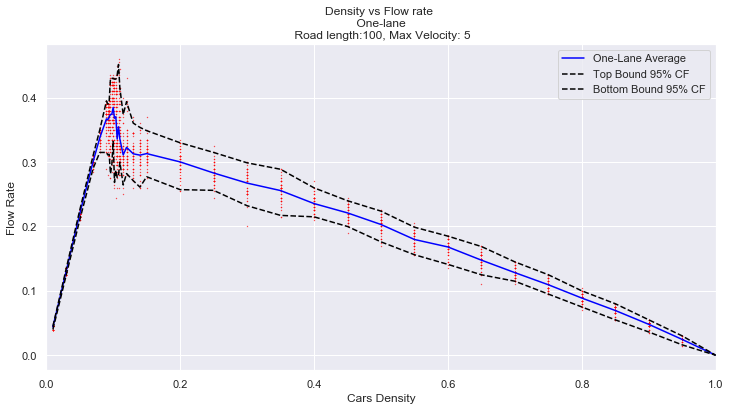

In [8]:
plt.figure(figsize=(12, 6))
sn.set()
#one lane:
plt.plot(densities_1,flow_rate_mean_1, label = 'One-Lane Average', color = 'blue' )
plt.plot(densities_1,top_1,  'k--', color = 'black', label = 'Top Bound 95% CF')
plt.plot(densities_1,Bottom_1,  'k--' , color = 'black', label = 'Bottom Bound 95% CF')
plt.scatter(densities_points_1,points_flow_1, color = 'red', s = .1 )
plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.title("Density vs Flow rate \n One-lane \n Road length:100, Max Velocity: 5")
plt.xlabel("Cars Density")
plt.ylabel("Flow Rate")
plt.legend()
plt.show()

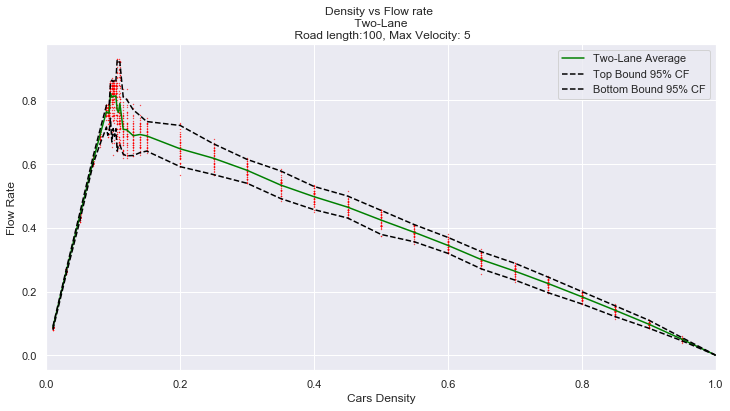

In [9]:
plt.figure(figsize=(12, 6))
sn.set()
#two lanes
plt.plot(densities_2,flow_rate_mean_2, label = 'Two-Lane Average', color = 'green' )
plt.plot(densities_2,top_2,  'k--', color = 'black', label = 'Top Bound 95% CF')
plt.plot(densities_2,Bottom_2,  'k--' , color = 'black', label = 'Bottom Bound 95% CF')
plt.scatter(densities_points_2,points_flow_2, color = 'red', s = .1 )
plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.title("Density vs Flow rate \n Two-Lane \n Road length:100, Max Velocity: 5")
plt.xlabel("Cars Density")
plt.ylabel("Flow Rate")
plt.legend()
plt.show()

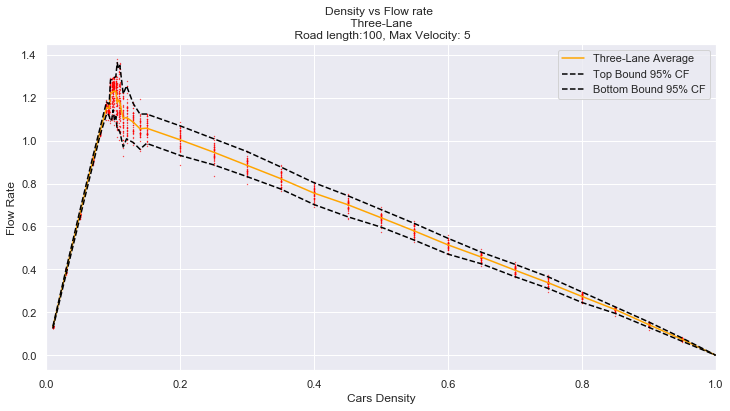

In [10]:
plt.figure(figsize=(12, 6))
sn.set()
#three lanes
plt.plot(densities_3,flow_rate_mean_3, label = 'Three-Lane Average', color = 'orange' )
plt.plot(densities_3,top_3,  'k--', color = 'black', label = 'Top Bound 95% CF')
plt.plot(densities_3,Bottom_3,  'k--' , color = 'black', label = 'Bottom Bound 95% CF')
plt.scatter(densities_points_3,points_flow_3, color = 'red', s = .1 )
plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.title("Density vs Flow rate \n Three-Lane \n Road length:100, Max Velocity: 5")
plt.xlabel("Cars Density")
plt.ylabel("Flow Rate")
plt.legend()
plt.show()

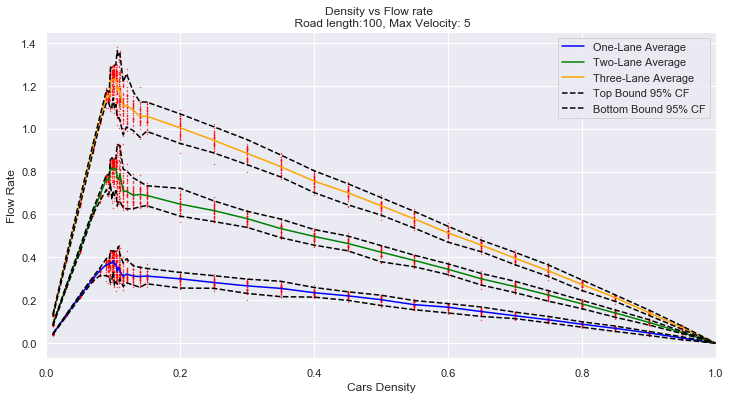

In [11]:
plt.figure(figsize=(12, 6))
sn.set()
#one lane:
plt.plot(densities_1,flow_rate_mean_1, label = 'One-Lane Average', color = 'blue' )
plt.plot(densities_1,top_1,  'k--', color = 'black')
plt.plot(densities_1,Bottom_1,  'k--' , color = 'black')
plt.scatter(densities_points_1,points_flow_1, color = 'red', s = .1 )

#two lanes
plt.plot(densities_2,flow_rate_mean_2, label = 'Two-Lane Average', color = 'green' )
plt.plot(densities_2,top_2,  'k--', color = 'black')
plt.plot(densities_2,Bottom_2,  'k--' , color = 'black')
plt.scatter(densities_points_2,points_flow_2, color = 'red', s = .1 )

#three lanes
plt.plot(densities_3,flow_rate_mean_3, label = 'Three-Lane Average', color = 'orange' )
plt.plot(densities_3,top_3,  'k--', color = 'black', label = 'Top Bound 95% CF')
plt.plot(densities_3,Bottom_3,  'k--' , color = 'black', label = 'Bottom Bound 95% CF')
plt.scatter(densities_points_3,points_flow_3, color = 'red', s = .1 )


plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.title("Density vs Flow rate \n Road length:100, Max Velocity: 5")
plt.xlabel("Cars Density")
plt.ylabel("Flow Rate")
plt.legend()

## Stretch Goal: Traffic Lights, Speed Limit, Obstacles, and Graphical Simulation

In [8]:
#Setting the initial paramters of the window
WIDTH=1300
HEIGHT=400
CAPTION = 'CS166 Simulation'
ALPHA = (0,255,0)


#Class to include graphical vector cars

class Cars(Sprite): #ingeriting the Sprite class from pygame 
    def __init__(self,x,y):
        Sprite.__init__(self)
        #upload and rescale the image of the cars
        #choose either a blue or a red one randomly
        self.photo = random.choice(['car.png', 'car2.png']) 
        self.image=image.load(r'D:/Courses/CS166/Graphics/'+self.photo)
        self.image = pygame.transform.scale(self.image,(50,50))
        
        # This is designed for two-lane simulation
        # y=220 for the first lane (array 0) and y=290 for the second lane (array 1)
        if y == 0:
            y= 220
        else:
            y = 290
            
        
        self.speed=int(x) # speed of the car and the x coordinate
        self.y=int(y) # y coordinate
        self.rect=self.image.get_rect(center = (self.speed,self.y)) #used to place the car
        self.speed = 0 #starting cars at constant

   


#building another class for traffic signal:

class Signal(Sprite):
    def __init__(self):
        Sprite.__init__(self)
        #upload and rescale the image
        self.image=image.load(r'D:/Courses/CS166/Graphics/green.png')
        self.rect=self.image.get_rect(center=(550,50))
    #A method to change the traffic light at each time step    
    def change_sign(self,color):
            self.image=image.load(color)
            
#building a class for speed limit signs on the road            
class Speed_Limit(Sprite):
    def __init__(self, photo, coordinates):
        #upload the image and rescale
        Sprite.__init__(self)
        self.image=image.load(r'D:/Courses/CS166/Graphics/'+photo)
        self.image = pygame.transform.scale(self.image,(50,50))
        self.rect=self.image.get_rect(center=coordinates)
        
#A class for chicken which will act as the obstacles on the road
class Chicken(Sprite):
    def __init__(self, coordinates):
        Sprite.__init__(self)
        #upload the image and rescale
        self.image=image.load(r'D:/Courses/CS166/Graphics/chicken.png')
        self.image = pygame.transform.scale(self.image,(50,50))
        self.rect=self.image.get_rect(center=coordinates)

In [9]:
#The following is the same class as the one we used above but it has been edited to
#include traffic, signals, cars and be compatible to pygame
#the graphical simulator has a limited screen width, so I'm forcing a maximum number of cars of 22 cars
#it also works only for one lane
#the road lenght is fixed at 1300 because that's the width of the screen (this is explained in the report)

class TrafficSimulator_extra(object):

    def __init__(self,road_length=1300,   max_velocity=11,prob_slowdown=.5, lanes_num=2, cars_number=5):
    
        #mostly same attributes as before:
        self.road_length = road_length
        self.max_velocity = max_velocity
        self.prob_slowdown= prob_slowdown
        self.prob_change_lane= 0.999
        self.flow_rate_counter = 0
        self.lanes_num = lanes_num
        self.chicken_x = None #the coordinates of the chicken (the obstacle)
        self.chicken_y= None
        self.chicken_on_the_way = False
        self.chicken_life =0
        #fixing the cars number to a maximum of 22 cars (more cars can't fit the screen)
        self.cars_number = cars_number
        
        
        self.current_state = np.array([[-1 for i in range(self.road_length)]]*self.lanes_num,  dtype=object)
        self.next_state = np.array([[-1 for i in range(self.road_length)]]*self.lanes_num,  dtype=object)
        
    #same function as before:
    def initialize(self):
        for i in range(self.lanes_num):
            random_indices = np.random.choice(
                range(0, self.road_length, 60),
                size=self.cars_number, replace =False) 
            for index in random_indices:
                self.current_state[i,index] = Cars(index,i)
       
        self.time = 0
        
        
 
        
    def update_lane(self, index, signal_counter):
        
        #setting the traffic light and speed limits:
        for i in range(self.road_length):
            
            #traffic lights:
            if i < 550 and i >490:
                if signal_counter ==2:
                    self.max_velocity = 0
            #speed limits
            elif i < 490:
                self.max_velocity = 5
            else:
                self.max_velocity = 11
                
            #the "chicken" will be a string ("stuck") in the road arrays
            
            if self.current_state[index][i] !=-1 and self.current_state[index][i]!="stuck":
                #calculate how many spaces are available for cars
                spaces = 1 
                while self.current_state[index][(i+spaces)%len(self.current_state[index])] ==-1:
                    spaces+=1
                #accelerate
                if self.current_state[index][i].speed < self.max_velocity :
                        self.current_state[index][i].speed = self.current_state[index][i].speed+1
                #decelerate
                #I'm subtracting 60 from the spaces because the lenght of the car image is 60
                if spaces-60 <= self.current_state[index][i].speed:
                    if spaces-60 < 0:
                        self.current_state[index][i].speed = 0
                    else:
                        self.current_state[index][i].speed = spaces-60 
                
                #randomization
                #here I'm also adding a possiblity of slowing down by 2 to see what happens
                if self.current_state[index][i].speed>0 and random.random() < self.prob_slowdown:
                        self.current_state[index][i].speed = self.current_state[index][i].speed-1
                elif self.current_state[index][i].speed>1 and random.random() < 0.2:
                    self.current_state[index][i].speed = self.current_state[index][i].speed-2
        
    
            
        #Moving the cars based on their velocities
        for j in range(self.road_length):
            if self.current_state[index][j] != -1 and self.current_state[index][j] != "stuck":
                self.next_state[index][(j+self.current_state[index][j].speed)%len(self.next_state[index])
                                      ] = self.current_state[index][j]
        
        #updating the current state after movement
        self.current_state[index] =  self.next_state[index]
        self.next_state = np.array([[-1 for i in range(self.road_length)]]*self.lanes_num, dtype=object)
        
        # throwing a random chicken on the road to be an obstacle
        if not self.chicken_on_the_way and random.random() <0.01:
            free = False
            while not free: #making sure that the cell where chicken goes is empty
                self.chicken_x = random.choice(range(1, 1300))
                if self.current_state[index][self.chicken_x] == -1:
                    free = True
            self.chicken_y = random.choice([0, 1])#randomly choosing the lane
            self.next_state[self.chicken_y,self.chicken_x] = "stuck"
            self.chicken_on_the_way = True
            self.chicken_life = 1 
            #chicken will stay dead on the road for 1000 time step then it gets removed
        if self.chicken_on_the_way:
            if self.chicken_life <1000:
                self.next_state[self.chicken_y,self.chicken_x] = "stuck"
                self.chicken_life += 1
            else:
                self.next_state[self.chicken_y,self.chicken_x] = -1 #remove the chicken
                self.chicken_on_the_way = False
                self.chicken_life = 0
            
        
       
        #calculate flow_rate
        for i in range(self.max_velocity):
            if self.current_state[index][i] != -1 and self.current_state[index][i] != 'stuck':
                if self.current_state[index][i].speed >i:
                    self.flow_rate_counter+=1
    
       
    #mostly same function as before:
    def change_lane(self, index_1):
        index_2 = (index_1+1)%self.lanes_num
        
        for i in range(self.road_length):
            
            if self.current_state[index_1][i] !=-1 and self.current_state[index_1][i] !='stuck':
                #calculate the gaps in front of me
                forward_gaps_l = 0 
                while self.current_state[index_1][(i+forward_gaps_l+1)%len(self.current_state[index_1])] ==-1:
                    forward_gaps_l+=1
                forward_gaps_l = forward_gaps_l-60
                #if spaces in front of me are not enough:
                
                num_1=self.current_state[index_1][i].speed+1
                if forward_gaps_l <= (num_1 - (num_1//(self.max_velocity+1) )):
                    #calculate spaces on the other lane
                    forward_spaces_lo = -1 
                    while self.current_state[index_2][(i+forward_spaces_lo+1)%len(self.current_state[index_1])] ==-1:
                        forward_spaces_lo+=1
                        num_2 = self.current_state[index_1][i].speed+1
                        if (forward_spaces_lo-60) >= (num_2 - (num_2//(self.max_velocity+1))):
                            break
                    #if gaps on other lane are enough:
                    num_2 = self.current_state[index_1][i].speed+1
                    if (forward_spaces_lo-60) >= (num_2 - (num_2//(self.max_velocity+1))):
                        #look behind:
                        cars_behind = False
                        
                        for j in range(60): #60 because the car image has a width of 60
                            #if there is a car coming:
                            if self.current_state[index_2][i-j]!='stuck'and self.current_state[index_2][i-j]!=-1:
                                #don't change
                                cars_behind = True
                            #change
                        if not cars_behind and random.random() < self.prob_change_lane:
                            self.current_state[index_2][i] = self.current_state[index_1][i]
                            self.current_state[index_1][i] = -1
                            #print('here changeee')
                    
    #same update function as before
    def update(self, signal_counter=None):
        if self.lanes_num>1:
            for i in range(self.lanes_num):
                self.change_lane(i)
        #
        for i in range(self.lanes_num):
            self.update_lane(i, signal_counter)
        #
        self.time += 1

        

In [10]:
clock = pygame.time.Clock() # clock of pygame


frame = pygame.display.set_mode((WIDTH, HEIGHT)) #start the window
display.set_caption(CAPTION) #add the caption


sim = TrafficSimulator_extra() #start the simulation class
sim.initialize()

my_cars = [] #get the car objects
for i in sim.current_state:
    for each_car in i:
        #for each cell, if it's car, then load it
        if type(each_car) != int and each_car != 'stuck' :
            my_cars.append(each_car)
    

#loading the signals, speed limits,  and cars
signal1=Signal()
limit_5 = Speed_Limit(photo = "speed_limit_5.jpg", coordinates = (200, 50))
limit_15 = Speed_Limit(photo = "speed_limit_15.jpg", coordinates = (700, 50))
all_limits = Group(limit_5,limit_15 )
all_cars=Group(my_cars)
all_signals=Group(signal1)



#traffic light colors
signal_list=[r'D:/Courses/CS166/Graphics/green.png',
             r'D:/Courses/CS166/Graphics/yellow.png',
             r'D:/Courses/CS166/Graphics/red.png'];


#initialize pygame
signal_counter=0;
pygame.init()


#adding the road as a background
road =image.load(r'D:/Courses/CS166/Graphics/road.png')
road_rect = road.get_rect()

road_2 =image.load(r'D:/Courses/CS166/Graphics/road.png')
road_rect_2 = road.get_rect()

#loading the random chicken obstacle
chicken_blit = image.load(r'D:/Courses/CS166/Graphics/chicken.png')
chicken_blit = pygame.transform.scale(chicken_blit,(50,50))
chicken_blit_rect= chicken_blit.get_rect()


FRAME_TIME = 40 # view simulation every 40 frames 
next_frame_time = pygame.time.get_ticks() + FRAME_TIME
current_time = next_frame_time

#Start!!!
while True:
   
    while True:
        
        event = pygame.event.poll() #get pygame going
        if event.type == pygame.NOEVENT:
            break
        
        # To quit, hit any key
        elif event.type == pygame.locals.KEYDOWN:
            pygame.quit()
    
    #move frames        
    pygame.display.flip()
    now = pygame.time.get_ticks()
    if now < next_frame_time:
        pygame.time.wait(next_frame_time - now)
    next_frame_time += FRAME_TIME
    
    # Adding the time for each color of the traffic light
    if signal_counter ==0:
        waiting_time = 9000
    elif signal_counter ==1:
        waiting_time = 2000
    elif signal_counter ==2:
        waiting_time = 9000
    
    #control traffic light based on the time above
    if next_frame_time - current_time ==waiting_time:
            current_time = next_frame_time
            signal_counter+=1
            if signal_counter>2:
                signal_counter=0
            signal1.change_sign(signal_list[signal_counter])
    
    
    #update the position of the cars using the simulation above
    my_cars=[]
    sim.update(signal_counter) #the update step
    
    for i, ndarray in enumerate(sim.current_state):
        for j, car in enumerate(ndarray):
            if car !=-1 and car!= 'stuck':
                # if the car changed lanes:
                if i==0 and car.rect.top !=195:
                    value = -70 # change lanes on graphics
                    car.image = transform.rotate(car.image, 45)
                elif i ==1 and car.rect.top !=265:
                    value = 70
                    car.image = transform.rotate(car.image, -45) #rotate it to make it seem it's changing lanes
                else:
                    car.image=image.load(r'D:/Courses/CS166/Graphics/'+car.photo) #put it back after rotation
                    car.image = pygame.transform.scale(car.image,(50,50))
                    value = 0 #if no lane change
                
                #move the car according to its index in the current_state array
                car.rect.top+=value 
                car.rect.left= (j)
                my_cars.append(car)
                
    #if simulation intialized the chicken, then take the coordinates and put it on graphics
    if sim.chicken_on_the_way:
        if sim.chicken_y == 0:
            y = 190
            #for top
        else:
            y = 280
            #for bottom
       
    
    #put all graphics mentioned above on the screen
    all_cars=Group(my_cars)
    frame.fill((255,255,255)) #for a white screen
    frame.blit(road, (930,-85)) #blit for background
    frame.blit(road_2, (0,-80)) # //
    
    if sim.chicken_on_the_way:
        frame.blit(chicken_blit, (sim.chicken_x,y))
    all_cars.draw(frame)
    all_signals.draw(frame)
    all_limits.draw(frame)
    
    display.update()
    pygame.display.flip() #flip frames
   
    
#if you see an error below, it's because the graphics screen has been closed

error: video system not initialized

In [15]:
#This cell takes 15 mins to run

densities_extra = []

flow_rate_mean_extra = []
flow_rate_lists_extra =[]
for cars_num in range(0, 23):
    densities_extra.append(cars_num/22)
    flow_rate_averager = []
    for i in range(50):
        sim = TrafficSimulator_extra(cars_number = cars_num)
        sim.initialize()
        #output of one density:
        for j in range(200):
            sim.update()
        flow_rate_averager.append(sim.flow_rate_counter/sim.time)
    flow_rate_lists_extra.append(flow_rate_averager)
    flow_rate_mean_extra.append(np.mean(flow_rate_averager))
    

top_extra = [np.quantile(i, 0.975) for i in flow_rate_lists_extra ]
Bottom_extra = [np.quantile(i, 0.025) for i in flow_rate_lists_extra ]
points_flow_extra = np.concatenate(flow_rate_lists_extra)
densities_points_extra = np.concatenate([[densities_extra[i]]*len(flow_rate_lists_extra[i]) for i in range(len(flow_rate_lists_extra)) ])


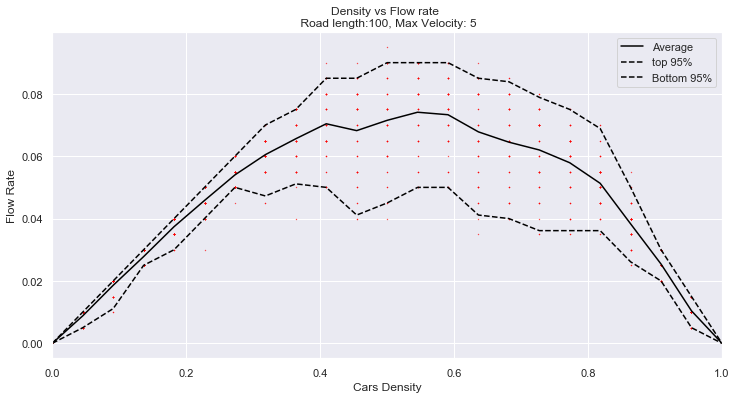

In [16]:
plt.figure(figsize=(12, 6))

plt.plot(densities_extra,flow_rate_mean_extra, label = 'Average', color = 'black' )
plt.plot(densities_extra,top_extra,  'k--', color = 'black', label = 'top 95%')
plt.plot(densities_extra,Bottom_extra,  'k--' , color = 'black', label = 'Bottom 95%')
plt.scatter(densities_points_extra,points_flow_extra, color = 'red', s = .1 )

plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.title("Density vs Flow rate \n Road length:100, Max Velocity: 5")
plt.xlabel("Cars Density")
plt.ylabel("Flow Rate")
plt.legend()

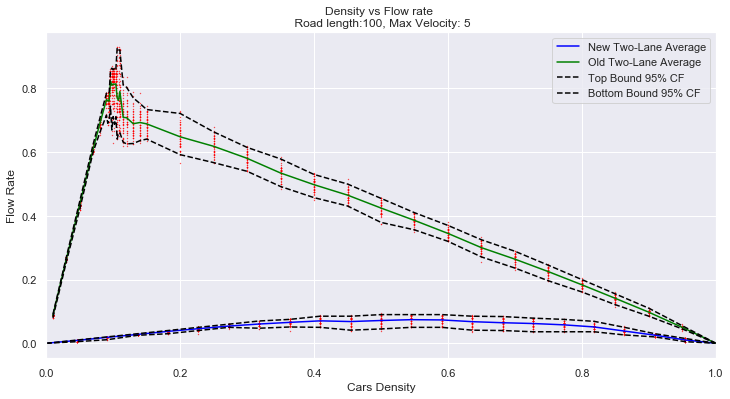

In [17]:
plt.figure(figsize=(12, 6))
sn.set()

plt.plot(densities_extra,flow_rate_mean_extra, label = 'New Two-Lane Average', color = 'blue' )
plt.plot(densities_extra,top_extra,  'k--', color = 'black')
plt.plot(densities_extra,Bottom_extra,  'k--' , color = 'black')
plt.scatter(densities_points_extra,points_flow_extra, color = 'red', s = .1 )

#two lanes
plt.plot(densities_2,flow_rate_mean_2, label = 'Old Two-Lane Average', color = 'green' )
plt.plot(densities_2,top_2,  'k--', color = 'black', label = 'Top Bound 95% CF')
plt.plot(densities_2,Bottom_2,  'k--' , color = 'black', label = 'Bottom Bound 95% CF')
plt.scatter(densities_points_2,points_flow_2, color = 'red', s = .1 )


plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.title("Density vs Flow rate \n Road length:100, Max Velocity: 5")
plt.xlabel("Cars Density")
plt.ylabel("Flow Rate")
plt.legend()